In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from src.utils import *
from experiments.data_utils import *
from experiments.plot_utils import *
from experiments.hyperparam_tuning import *

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
target = 'performance' # performance, regression
data = 'bugbug_szz' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'roc_auc' # roc_auc, average_precision
model = 'rf' # lr, svm, mlp, rf, xgb
feature_type = 'traditional' # traditional, bow

In [5]:
output_dir = 'experiments/results'

In [6]:
get_ml_data = get_ml_data_traditional if feature_type == 'traditional' else get_ml_data_bow

data_map = {
    'bugbug_buglevel': lambda target: get_ml_data('bugbug', target, kind='buglevel'),
    'bugbug_szz': lambda target: get_ml_data('bugbug_szz', target, kind='commitlevel'),
    'fixed_defect_szz': lambda target: get_ml_data('fixed_defect_szz', target, kind='commitlevel')
}

In [7]:
def get_results(data, feature_type, target, scoring, model):
    path = os.path.join(output_dir, f'{data}_{feature_type}_{target}_{scoring}_{model}.csv')
    results = pd.read_csv(path, index_col=0)
    if model == 'svm':
        results = results.drop('param_kernel__gamma', axis=1, errors='ignore')
    results = results.replace({np.nan: None})
    return results
results = get_results(data, feature_type, target, scoring, model)
results

,param_model,param_model__max_depth,param_model__min_samples_split,param_model__n_estimators,param_sampler,mean_fit_time,std_fit_time,mean_test_score,std_test_score,rank_test_score
17,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.775085,0.383149,0.775552,0.015799,1
71,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.732983,0.390042,0.775552,0.015799,1
14,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.758890,0.126997,0.775552,0.015799,1
84,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.026658,0.245133,0.775552,0.015799,1
27,RandomForestClassifier,None,2,150,RandomUnderSampler(random_state=0),1.751893,0.378498,0.775552,0.015799,1
...,...,...,...,...,...,...,...,...,...,...
25,RandomForestClassifier,20.0,2,5,RandomOverSampler(random_state=0),10.177250,2.404207,0.656387,0.015048,96
11,RandomForestClassifier,20.0,5,5,RandomOverSampler(random_state=0),11.107923,2.376426,0.656387,0.015048,96
13,RandomForestClassifier,None,2,5,SMOTE(random_state=0),36.590157,8.066854,0.613069,0.031139,98
42,RandomForestClassifier,None,5,5,SMOTE(random_state=0),22.053792,6.298486,0.610252,0.034565,99


In [8]:
X, y, features = data_map[data](target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

performance: 317 positive 0.34% - negative 91871 99.66%
X.shape=(92188, 301)



In [9]:
def get_params(results):
    params = results[[c for c in results.columns if 'param' in c]]
    params = params.rename(lambda c: c[6:], axis=1) # remove param_
    return params
params = get_params(results)

In [10]:
model_map = {
    'lr': LogisticRegression(random_state=0, solver='saga'),
    'svm': LinearSVC(random_state=0),
    'mlp': MLPClassifier(random_state=0),
    'rf': RandomForestClassifier(random_state=0),
    'xgb': xgboost.XGBClassifier(random_state=0, n_jobs=4, use_label_encoder=False, eval_metric='logloss')
}

In [11]:
def get_best_params(model, params):
    best_params = dict(params.iloc[0])

    best_params['model'] = model_map[model]
    try:
        best_params['sampler'] = eval(best_params['sampler'])
    except:
        best_params['sampler'] = None

    # for k, v in best_params.items():
    #     if np.isnan(v):
    #         best_params[k] = None
    
    return best_params

best_params = get_best_params(model, params)
best_params

{'model': RandomForestClassifier(random_state=0),
 'model__max_depth': None,
 'model__min_samples_split': 2,
 'model__n_estimators': 150,
 'sampler': RandomUnderSampler(random_state=0)}

In [12]:
pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
pipeline.set_params(**best_params)
pipeline

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sampler', RandomUnderSampler(random_state=0)),
                ('model',
                 RandomForestClassifier(n_estimators=150, random_state=0))])

In [ ]:
results.iloc[0]

In [ ]:
from sklearn.model_selection import cross_val_score
y_test_proportion = len(y_test) / (len(y_train) + len(y_test))
tscv = TimeSeriesSplit(n_splits=5, test_size=round(len(y_train) * y_test_proportion))
res = cross_val_score(pipeline, X_train, y_train, scoring=scoring, cv=tscv, n_jobs=5)
res, res.mean(), res.std()

In [ ]:
for ix_train, ix_val in tscv.split(X_train, y_train):
    print(f'{ix_train=}, {ix_val=}')
    print(f'{y_train[ix_train].sum()=}, {y_train[ix_val].sum()=}')
    pipeline.fit(X_train[ix_train, :], y_train[ix_train])

    y_score = pipeline.predict_proba(X_train[ix_val, :])[:,1]
    print('ROC AUC:', metrics.roc_auc_score(y_train[ix_val], y_score))
    print('AVG PREC:', metrics.average_precision_score(y_train[ix_val], y_score))
    plot_roc_curve(pipeline, X_train[ix_val, :], y_train[ix_val])
    plot_precision_recall_curve_with_f1(pipeline,  X_train[ix_val, :], y_train[ix_val])

In [ ]:
pipeline.fit(X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_train)[:,1]
metrics.roc_auc_score(y_train, y_score), metrics.average_precision_score(y_train, y_score)

In [ ]:
plot_roc_curve(pipeline, X_train, y_train)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_train, y_train)

In [ ]:
y_score = pipeline.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test, y_score), metrics.average_precision_score(y_test, y_score)

In [ ]:
plot_roc_curve(pipeline, X_test, y_test)

In [ ]:
plot_precision_recall_curve_with_f1(pipeline, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.boxplot(results['mean_test_score'])

In [ ]:
make_directory('experiments/plots')

In [85]:
def fit_all_models(target, data, feature_type, scoring):
    X, y, features = data_map[data](target)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

    fitted_pipelines = []
    for model in ['lr', 'svm', 'mlp', 'rf', 'xgb']:
        print(model)
        results = get_results(data, feature_type, target, scoring, model)
        params = get_params(results)
        best_params = get_best_params(model, params)
        print(best_params)

        pipeline = default_pipeline() if model != 'svm' else svm_pipeline()
        pipeline.set_params(**best_params) 

        pipeline.fit(X_train, y_train)
        fitted_pipelines.append((model, pipeline))

    return fitted_pipelines, X_train, X_test, y_train, y_test
    

In [86]:
def plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test):
    _X = X_test
    _y = y_test

    roc_fig, roc_ax = plt.subplots(figsize=(12,8))
    roc_ax.axline([0,0], [1,1], color='black')
    roc_ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate', title='ROC Curve')

    pr_fig, pr_ax = plt.subplots(figsize=(12,8))
    R, P = np.meshgrid(np.linspace(0,1,100), np.linspace(0,1,100))
    F1 = 2 * R * P / (R + P)
    CS = pr_ax.contour(R, P, F1, levels=np.arange(0.1, 1, 0.1), alpha=0.5, colors='gray')
    pr_ax.clabel(CS, inline=1)
    pr_ax.set(xlabel='Recall', ylabel='Precision', title='Recall-Precision Curve')


    for (model, pipeline) in fitted_pipelines:

        if type(pipeline['model']) is LinearSVC:
            y_score = pipeline.decision_function(_X)
        else:
            y_score = pipeline.predict_proba(_X)[:,1]

        fpr, tpr, thresholds = metrics.roc_curve(_y, y_score)
        roc_ax.plot(fpr, tpr, label=model)
        
        precision, recall, thresholds = metrics.precision_recall_curve(_y, y_score)
        pr_ax.plot(recall, precision, label=model)

    roc_ax.legend()
    pr_ax.legend()

    roc_fig.tight_layout()
    roc_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_roc.pdf')

    pr_fig.tight_layout()
    pr_fig.savefig(f'experiments/plots/{data}_{feature_type}_{target}_{scoring}_pr.pdf')
    plt.show()


In [87]:
target = 'regression' # performance, regression
data = 'bugbug_buglevel' # bugbug_buglevel, bugbug_szz, fixed_defect_szz
scoring = 'average_precision' # roc_auc, average_precision

performance: 317 positive 0.34% - negative 91871 99.66% 
X.shape=(92188, 301)

lr
{'model': LogisticRegression(C=0.1205828199813305, penalty='l1', random_state=0,
                   solver='saga'), 'model__C': 0.1205828199813305, 'model__penalty': 'l1', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=3.5815547622959314, random_state=0), 'model__C': 3.5815547622959314, 'sampler': RandomOverSampler(random_state=0)}
mlp
{'model': MLPClassifier(activation='tanh', alpha=0.2939941484502139,
              hidden_layer_sizes=200, learning_rate_init=0.0001,
              random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.2939941484502139, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0001, 'sampler': SMOTE(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(max_depth=nan, n_estimators=150, random_state=0), 'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 150, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=3, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=35, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 1.0, 'model__max_delta_step': 1, 'model__max_depth

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


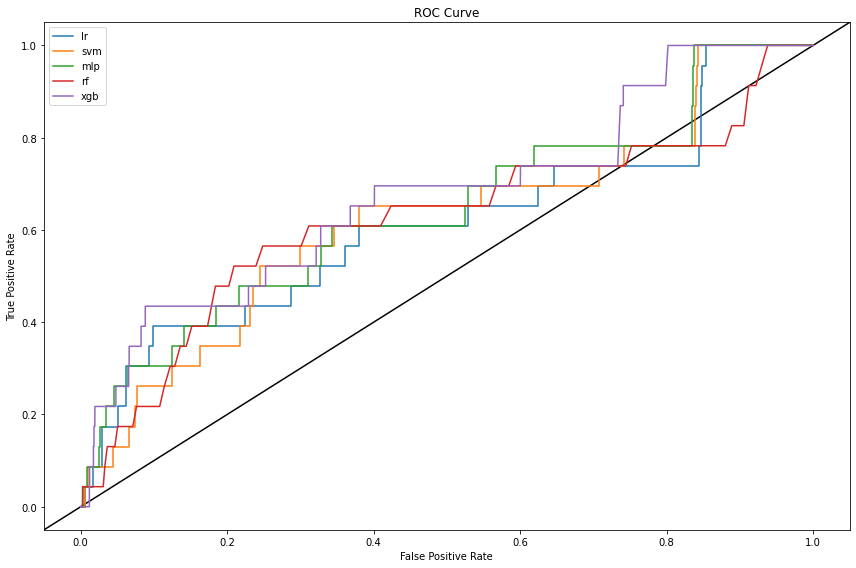

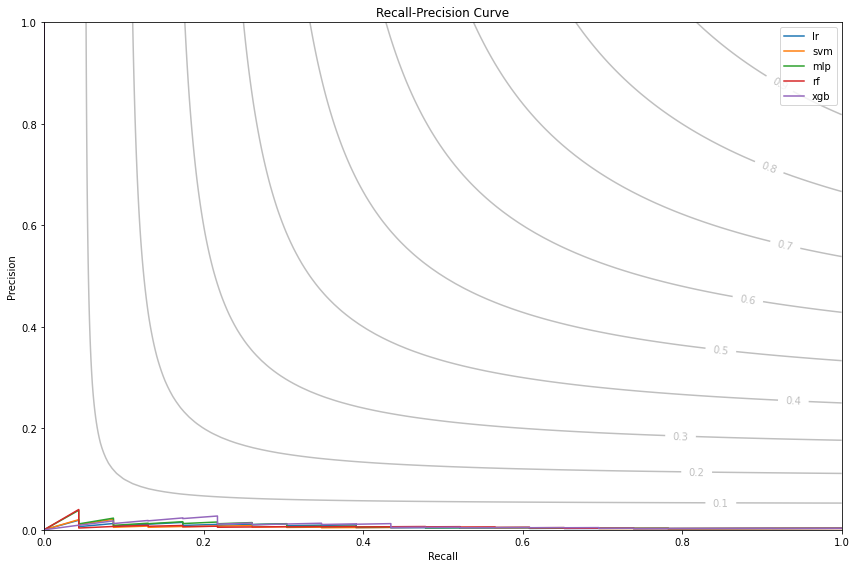

In [97]:
fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, feature_type, scoring)
plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test)

target='performance', data='bugbug_buglevel', scoring='roc_auc'
performance: 1452 positive 2.41% - negative 58910 97.59% 
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.1205828199813305, penalty='l1', random_state=0,
                   solver='saga'), 'model__C': 0.0585581498080432, 'model__penalty': 'l1', 'sampler': RandomOverSampler(random_state=0)}
svm
{'kernel__degree': 3, 'kernel__kernel': 'poly', 'model': LinearSVC(C=3.5815547622959314, random_state=0), 'model__C': 2.0124566418601693, 'sampler': RandomOverSampler(random_state=0)}
mlp
{'model': MLPClassifier(activation='tanh', alpha=0.2939941484502139,
              hidden_layer_sizes=200, learning_rate_init=0.0001,
              random_state=0), 'model__activation': 'logistic', 'model__alpha': 0.001456139498325, 'model__hidden_layer_sizes': 10, 'model__learning_rate_init': 0.0009480922762678, 'sampler': RandomUnderSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(n_estimators=150, random_state=0), 'model__max_depth': 20.0, 'model__min_samples_split': 2, 'model__n_estimators': 150, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=3, min_child_weight=5, missing=nan,
              monotone_constraints='()', n_estimators=54, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 0.0966836664049462, 'model__max_delta_step': 1, 'model__max_depth

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


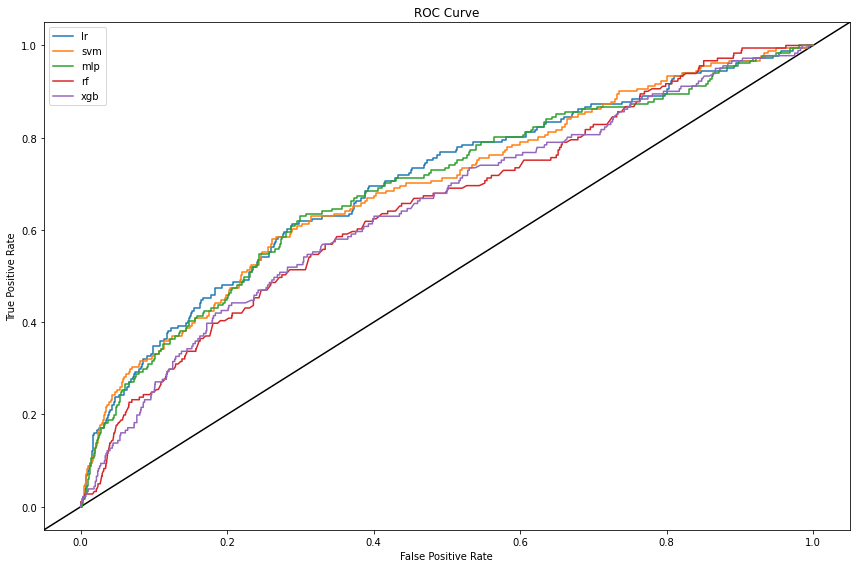

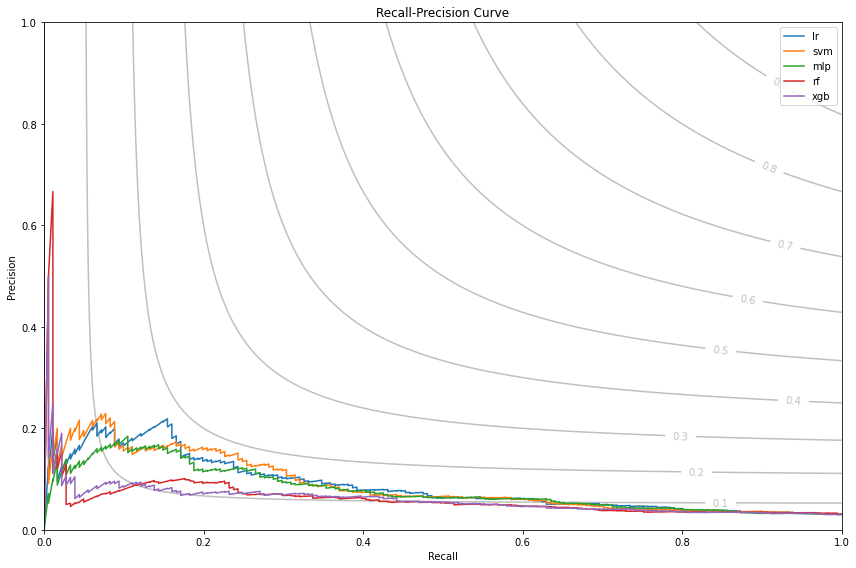

target='regression', data='bugbug_buglevel', scoring='roc_auc'
regression: 11552 positive 19.14% - negative 48810 80.86% 
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.0585581498080432, penalty='l1', random_state=0,
                   solver='saga'), 'model__C': 0.2883617416263422, 'model__penalty': 'l1', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=2.0124566418601693, random_state=0), 'model__C': 341.41455089164424, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(activation='logistic', alpha=0.001456139498325,
              hidden_layer_sizes=10, learning_rate_init=0.0009480922762678,
              random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': 50, 'model__learning_rate_init': 0.000324846990932, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(max_depth=20.0, n_estimators=150, random_state=0), 'model__max_depth': 15.0, 'model__min_samples_split': 2, 'model__n_estimators': 150, 'sampler': None}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.0966836664049462, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=1, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=52, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 0.0, 'model__max_delta_step': 1, 'model__max_depth': 3, 'model__

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


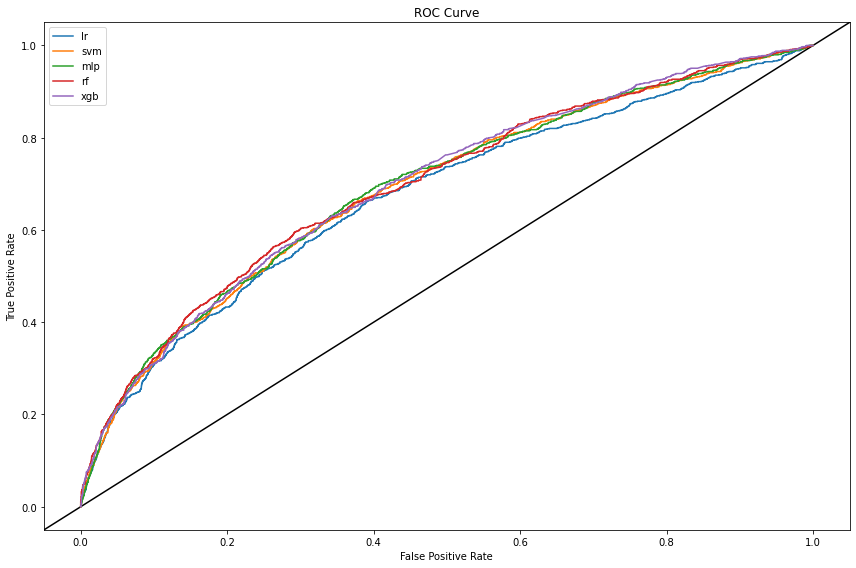

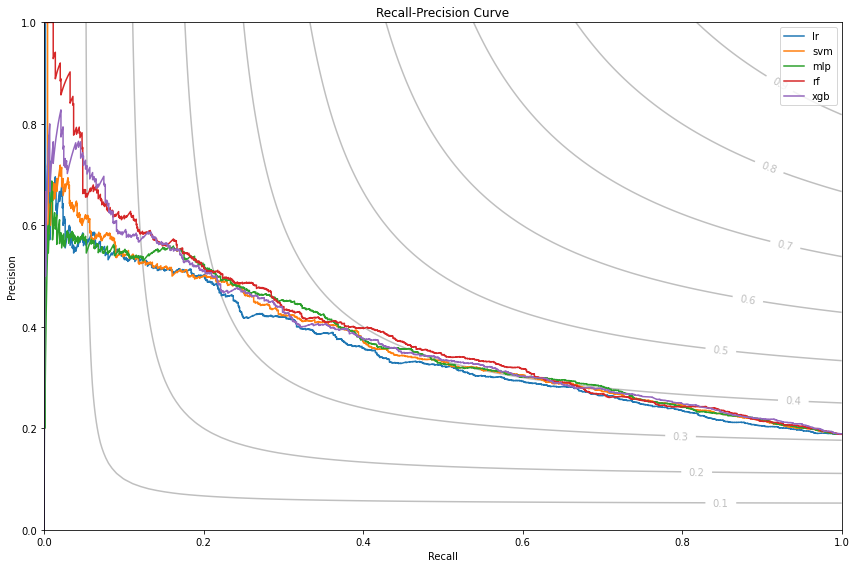

target='performance', data='bugbug_szz', scoring='roc_auc'
performance: 317 positive 0.34% - negative 91871 99.66% 
X.shape=(92188, 301)

lr
{'model': LogisticRegression(C=0.2883617416263422, penalty='l1', random_state=0,
                   solver='saga'), 'model__C': 0.1205828199813305, 'model__penalty': 'l1', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=341.41455089164424, random_state=0), 'model__C': 3.5815547622959314, 'sampler': RandomOverSampler(random_state=0)}
mlp
{'model': MLPClassifier(activation='tanh', hidden_layer_sizes=50,
              learning_rate_init=0.000324846990932, random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.2939941484502139, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0001, 'sampler': SMOTE(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(max_depth=15.0, n_estimators=150, random_state=0), 'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 150, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=3, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=35, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 1.0, 'model__max_delta_step': 1, 'model__max_dept

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


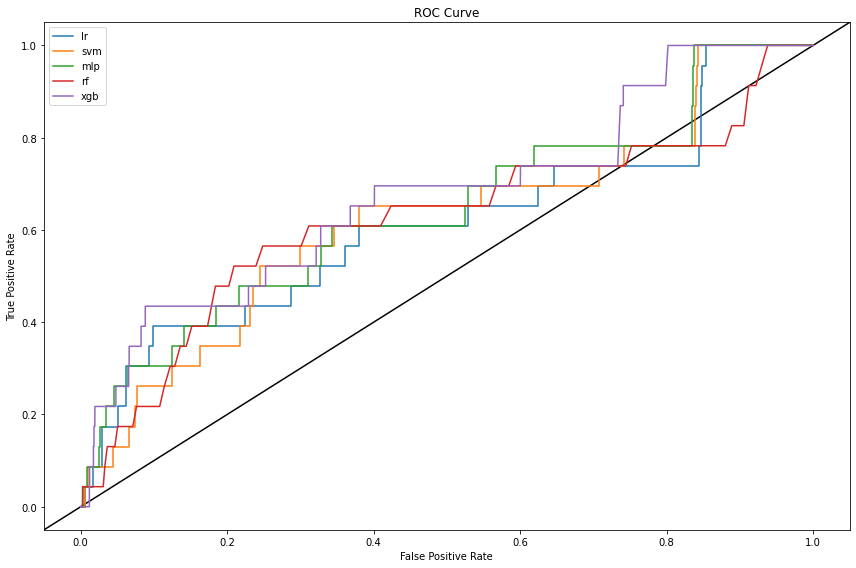

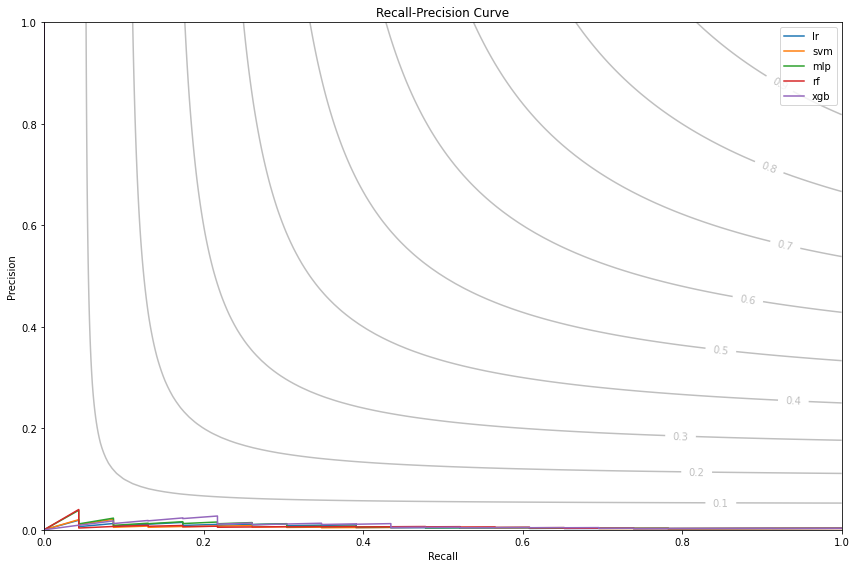

target='performance', data='fixed_defect_szz', scoring='roc_auc'
performance: 567 positive 0.62% - negative 91621 99.38% 
X.shape=(92188, 301)

lr
{'model': LogisticRegression(C=0.1205828199813305, penalty='l1', random_state=0,
                   solver='saga'), 'model__C': 0.6164166677244911, 'model__penalty': 'l2', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=3.5815547622959314, random_state=0), 'model__C': 1.1977742497224202, 'sampler': RandomOverSampler(random_state=0)}
mlp
{'model': MLPClassifier(activation='tanh', alpha=0.2939941484502139,
              hidden_layer_sizes=200, learning_rate_init=0.0001,
              random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': 100, 'model__learning_rate_init': 0.0004206230679296, 'sampler': None}
rf
{'model': RandomForestClassifier(n_estimators=150, random_state=0), 'model__max_depth': 5.0, 'model__min_samples_split': 5, 'model__n_estimators': 101, 'sampler': RandomOverSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', lear

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


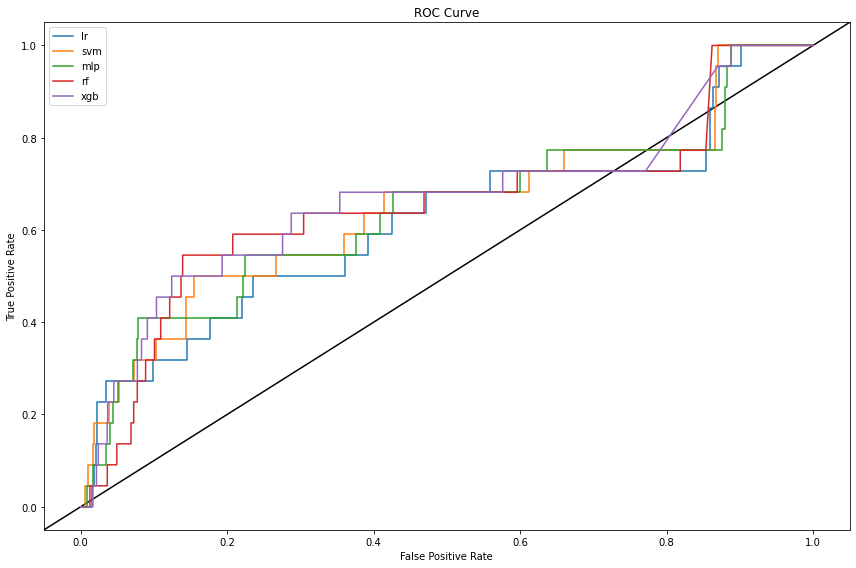

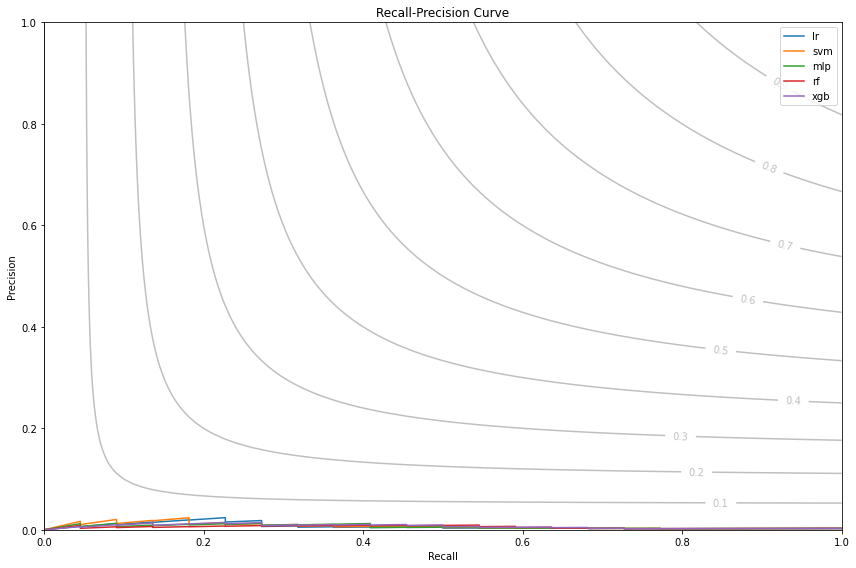

target='performance', data='bugbug_buglevel', scoring='average_precision'
performance: 1452 positive 2.41% - negative 58910 97.59% 
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.6164166677244911, random_state=0, solver='saga'), 'model__C': 0.021059163929894, 'model__penalty': 'l2', 'sampler': SMOTE(random_state=0)}
svm
{'kernel__degree': 5, 'kernel__kernel': 'linear', 'model': LinearSVC(C=1.1977742497224202, random_state=0), 'model__C': 7.156090624884973, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(activation='tanh', hidden_layer_sizes=100,
              learning_rate_init=0.0004206230679296, random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.2431362008261892, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0041238725976079, 'sampler': SMOTE(random_state=0)}
rf
{'model': RandomForestClassifier(max_depth=5.0, min_samples_split=5, n_estimators=101,
                       random_state=0), 'model__max_depth': 10.0, 'model__min_samples_split': 2, 'model__n_estimators': 114, 'sampler': RandomUnderSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=2, missing=nan,
              monotone_c

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


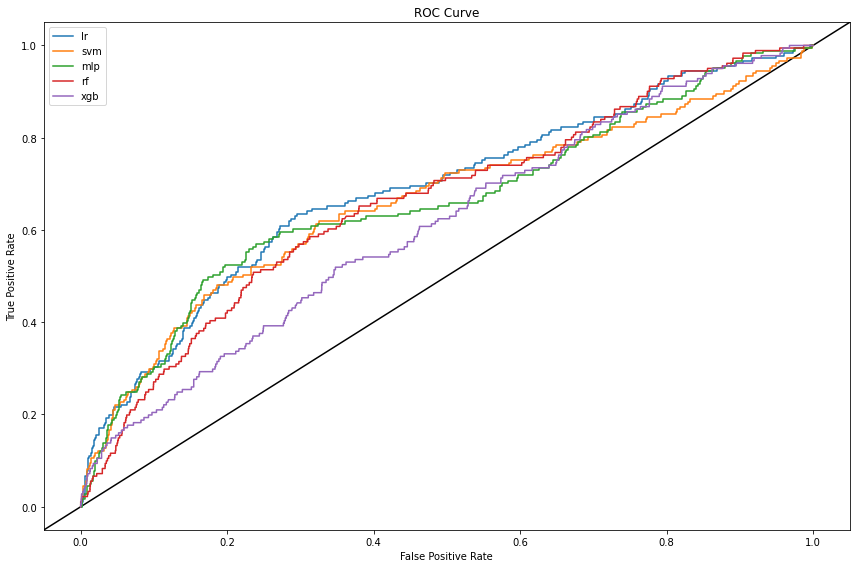

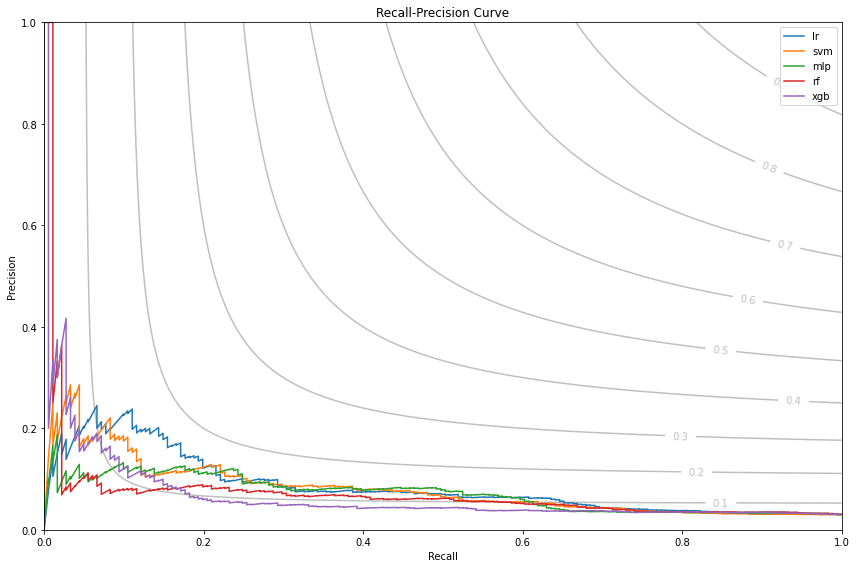

target='regression', data='bugbug_buglevel', scoring='average_precision'
regression: 11552 positive 19.14% - negative 48810 80.86% 
X.shape=(60362, 302)

lr
{'model': LogisticRegression(C=0.021059163929894, random_state=0, solver='saga'), 'model__C': 5.402024656860861, 'model__penalty': 'l2', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=7.156090624884973, random_state=0), 'model__C': 164.87171291936357, 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(activation='tanh', alpha=0.2431362008261892,
              hidden_layer_sizes=200, learning_rate_init=0.0041238725976079,
              random_state=0), 'model__activation': 'relu', 'model__alpha': 0.0134505118791459, 'model__hidden_layer_sizes': 100, 'model__learning_rate_init': 0.0001, 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(max_depth=10.0, n_estimators=114, random_state=0), 'model__max_depth': 15.0, 'model__min_samples_split': 2, 'model__n_estimators': 150, 'sampler': None}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=38, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 0.3613721957013188, 'model__max_delta_step': 0, 'model__max_depth': 3, 'model_

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


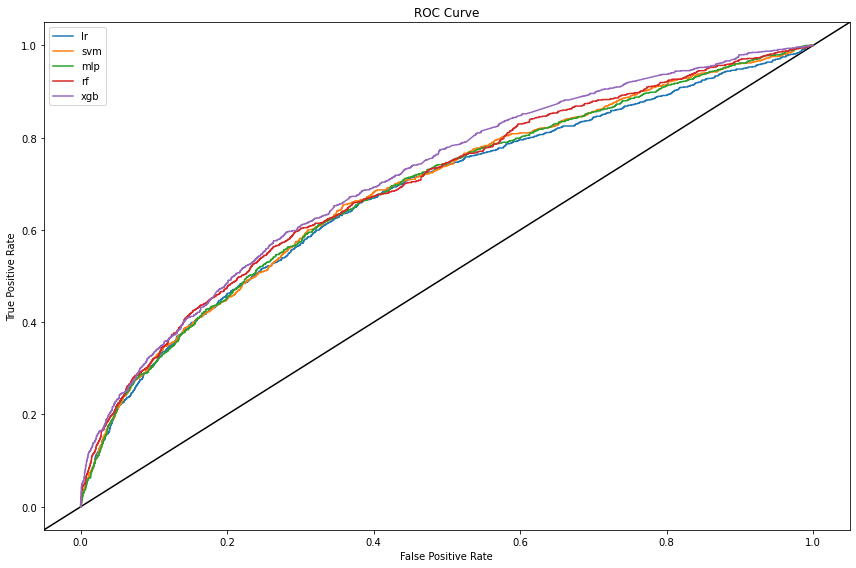

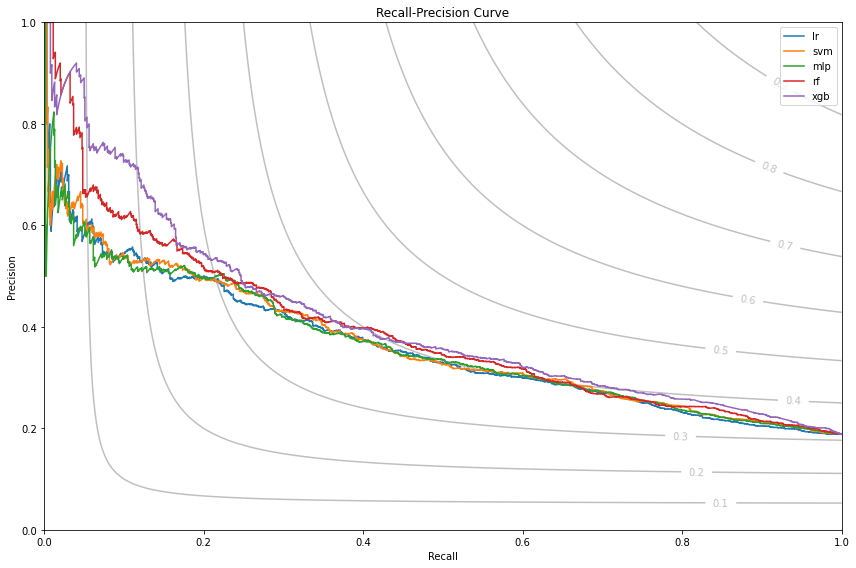

target='performance', data='bugbug_szz', scoring='average_precision'
performance: 317 positive 0.34% - negative 91871 99.66% 
X.shape=(92188, 301)

lr
{'model': LogisticRegression(C=5.402024656860861, random_state=0, solver='saga'), 'model__C': 1.0897088644522015, 'model__penalty': 'l2', 'sampler': RandomOverSampler(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=164.87171291936357, random_state=0), 'model__C': 29.10332575256947, 'sampler': SMOTE(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mlp
{'model': MLPClassifier(alpha=0.0134505118791459, hidden_layer_sizes=100,
              learning_rate_init=0.0001, random_state=0), 'model__activation': 'relu', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': 200, 'model__learning_rate_init': 0.0001, 'sampler': SMOTE(random_state=0)}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


rf
{'model': RandomForestClassifier(max_depth=15.0, n_estimators=150, random_state=0), 'model__max_depth': 5.0, 'model__min_samples_split': 2, 'model__n_estimators': 50, 'sampler': RandomOverSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0.3613721957013188, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=59, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None), 'model__gamma': 1.0, 'model__max_delta_step': 1, 'mod

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


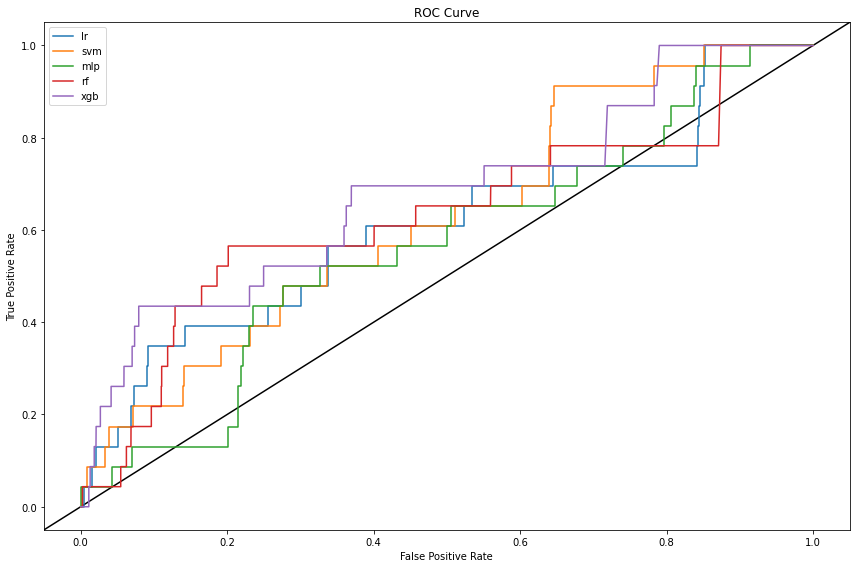

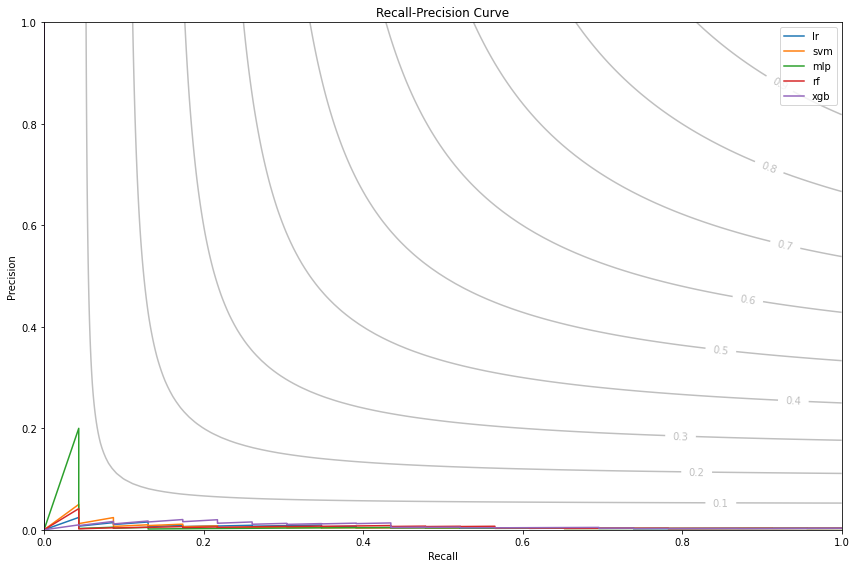

target='performance', data='fixed_defect_szz', scoring='average_precision'
performance: 567 positive 0.62% - negative 91621 99.38% 
X.shape=(92188, 301)

lr
{'model': LogisticRegression(C=1.0897088644522015, random_state=0, solver='saga'), 'model__C': 0.0163885959174532, 'model__penalty': 'l2', 'sampler': None}


/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


svm
{'kernel__degree': 3, 'kernel__kernel': 'rbf', 'model': LinearSVC(C=29.10332575256947, random_state=0), 'model__C': 3.278183917286776, 'sampler': None}
mlp
{'model': MLPClassifier(hidden_layer_sizes=200, learning_rate_init=0.0001, random_state=0), 'model__activation': 'tanh', 'model__alpha': 0.0001, 'model__hidden_layer_sizes': 10, 'model__learning_rate_init': 0.0014942832360619, 'sampler': None}
rf
{'model': RandomForestClassifier(max_depth=5.0, n_estimators=50, random_state=0), 'model__max_depth': 20.0, 'model__min_samples_split': 5, 'model__n_estimators': 150, 'sampler': RandomOverSampler(random_state=0)}
xgb
{'model': XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=1.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=1, max_depth=3, min_child_weight=5, mi

/tmp/ipykernel_9546/2872003585.py:11: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * R * P / (R + P)


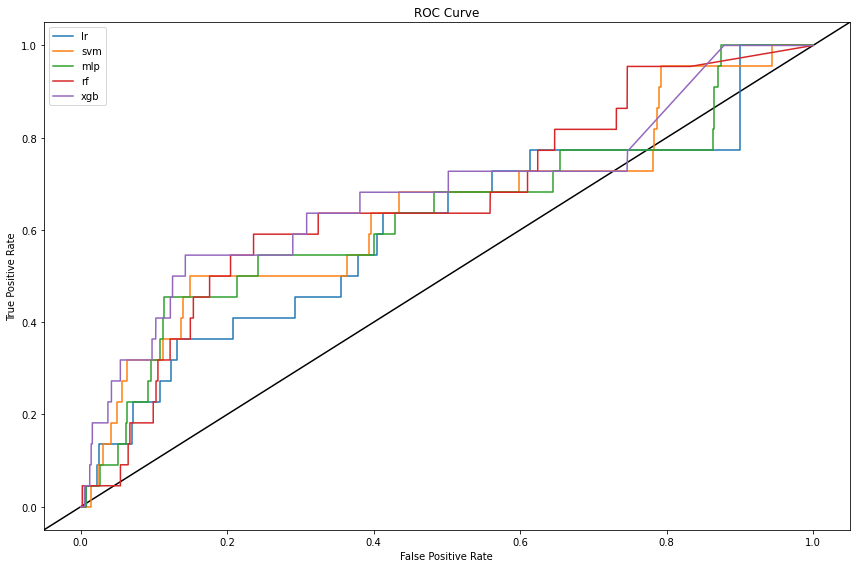

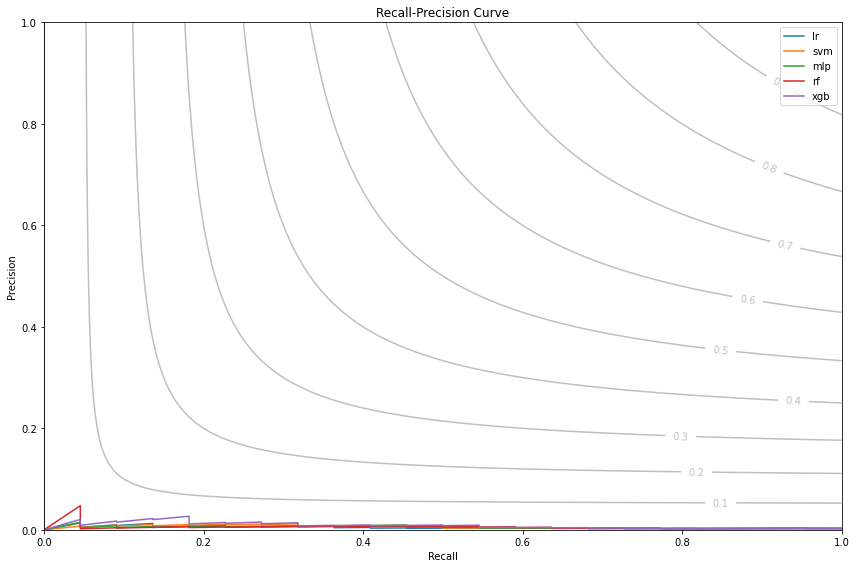

In [98]:
feature_type = 'traditional'
for target, data, scoring in [
    ('performance', 'bugbug_buglevel', 'roc_auc'),
    ('regression', 'bugbug_buglevel', 'roc_auc'),
    ('performance', 'bugbug_szz', 'roc_auc'),
    ('performance', 'fixed_defect_szz', 'roc_auc'),
    
    ('performance', 'bugbug_buglevel', 'average_precision'),
    ('regression', 'bugbug_buglevel', 'average_precision'),
    ('performance', 'bugbug_szz', 'average_precision'),
    ('performance', 'fixed_defect_szz', 'average_precision'),
]:
    print(f'{target=}, {data=}, {feature_type=}, {scoring=}')
    fitted_pipelines, X_train, X_test, y_train, y_test = fit_all_models(target, data, scoring)
    plot_roc_auc_rec_prec_for_all_models(target, data, feature_type, scoring, fitted_pipelines, X_train, X_test, y_train, y_test)

In [ ]:
pipeline.decision_function(X_test)

In [ ]:
type(pipeline['model']) is LinearSVC